# Car Price prediction

![cars](http://1.bp.blogspot.com/-Iq9Y1Ex6M8I/VkpRygq69EI/AAAAAAAAD6o/SaUWI7QtPqk/s1600/Audi-RS-5-BMW-M3-Mercedes-C-63-AMG-1200x800-731268a2f334fcee%2B%25281%2529.jpg)

## Прогнозирование стоимости автомобиля по характеристикам
Необходимо построить модель, которая будет распознавать изображения и обрабатывать текст.

In [ ]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 1.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 825 kB/s 
     |████████████████████████████████| 8.2 MB 11.8 MB/s 


In [ ]:
#аугментации изображений
!pip install albumentations -q

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression, mutual_info_regression

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option('display.max_rows', 50)  
pd.set_option('display.max_columns', 50)

# определяем функции

'''функция для подсчета пропущенных значений и их процента от общего числа значений'''


def missing_table(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table



'''функция, выводящая средние показатели: mean, median, mode'''


def mid_val(df, column):
    median = df[column].median()
    mode = df[column].mode()
    mean = df[column].mean()
    return display(
        pd.DataFrame({
            'Признак': column,
            'Медиана': median,
            'Среднее': mean,
            'Мода': mode
        }))



'''функция, выводящая все уникальные значения и их количество'''


def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    s = sns.catplot(x=column, kind="count", palette="Blues", data=df)
    s.set_xticklabels(rotation=90)


    
'''функция для вывода краткой описательной статистики'''


def desc_stat(df, column):
    minimum = df[column].min()
    maximum = df[column].max()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print(
        'Минимальное значение: {}'.format(minimum),
        '\nМаксимальное значение: {}'.format(maximum),
        '\n25-й перцентиль: {}'.format(perc25),
        '\n75-й перцентиль: {}'.format(perc75), '\nIQR: {}'.format(IQR),
        '\nГраницы выбросов: [{f}, {l}]'.format(f=perc25 - 1.5 * IQR,
                                                l=perc75 + 1.5 * IQR))


'''функция, определяющая границы выбросов'''


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [10, 90])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound



'''функция для опеределения средней стоимости автомобиля по категориям признака'''


def mean_price_by(df, column):
    return df.groupby([column])[['price'
                                    ]].mean().sort_values(['price'],
                                                          ascending=False)


'''функция, определяющая распределение средней стоимости автомобиля относительно его возраста'''


def price_by(df, column):
    return df.groupby(
        df[column])['price'].mean().to_frame().reset_index().sort_values(
            by=[column]).plot.line(x=column, y='price')


'''функция для построения графика зависимости от целевого признака'''


def price_plot(df, column):
    return sns.lmplot(x=column,
                      y="price",
                      data=df,
                      markers=["o"],
                      palette="Set1")


'''функция, определяющая среднюю абсолютную ошибку в процентах'''


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


from sklearn.metrics import make_scorer
# отмечаем функцию для скоринга
mape_score = make_scorer(mape, greater_is_better=False)


# функция для указания возраста автомобиля


def ownership_length(row):
    y_list = ['лет', 'год']
    m_list = ['месяцев','месяца']
    months = []
    if 'указано' in row:
        return 0
    else:
        row_list = row.split()
        for i in row_list:
            if i in y_list:
                index = row_list.index(i)
                months.append(12*int(row_list[index-1]))
            elif i in m_list:
                index = row_list.index(i)
                months.append(int(row_list[index-1]))
                return sum(months)
    
    
    
    ######### получние облака слов ##################
from wordcloud import WordCloud, STOPWORDS

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=russian_stopwords,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [ ]:
import math
from keras.callbacks import Callback
from keras import backend as K


class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# PreProc Tabular Data

In [ ]:
#используем все текстовые признаки как категориальные без предобработки
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
num_cols = ['engineDisplacement','enginePower','mileage', 'modelDate', 'productionDate']

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
def preproc_data(df_input):
    
    # копируем датасет
    
    df_output = df_input.copy()
    
    # заполним пропущенные значения модой
    
    df_output['Владельцы'] = df_output['Владельцы'].fillna(df_output['Владельцы'].mode()[0])
    
    # заполним пропущенные значения другой категорией в признаке "Владение"

    df_output['Владение'] = df_output['Владение'].fillna('Не указано')
    
    # улучшаем читабельность признака Владения
    
    df_output['Владение'] = df_output['Владение'].apply(ownership_length)
    
    # Убираем все приставки "LTR" в признаке engineDisplacement, и преобразуем признак в форму вещественных чисел

    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: x.split(' ')[0])
    
    # Замена объема двигателя электрокаров на 0

    df_output['engineDisplacement'] = df_output['engineDisplacement'].replace('undefined',0, regex=True)
    df_output['engineDisplacement']=df_output['engineDisplacement'].astype('float')
    
    # Приставка N12 также везде, избавимся от нее и переведем в формат целых чисел

    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: x.split(' ')[0]).astype('int64')
    
    df_output['numberOfDoors'] = df_output['numberOfDoors'].apply(lambda x: str(int(x)))
    
    df_output['vehicle_age'] = 2021 - df_output['productionDate'] 
    
    # создание признака 4WD
    four_wd = []
    for index, row in df_output['name'].items():
        if '4WD' in row:
            four_wd.append(index)
    
    df_output['4WD'] = 0
    for n, i in enumerate(four_wd):
        df_output.loc[i, '4WD'] = 1
    
   
    num_cols.append('vehicle_age')
    cat_cols.append('4WD')
    #cat_cols.append('xDrive')
    
    # категориальные признаки
    for column in cat_cols:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # удаление коррелирующих и не нужных для модели признаков
    df_output.drop(['sell_id', 'description'], axis = 1, inplace=True)
    
    df_output = pd.get_dummies(df_output, columns=cat_cols, dummy_na=False, drop_first=True)
    
    
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,vehicle_age,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_1,...,Владение_101,Владение_102,Владение_103,Владение_104,Владение_105,Владение_106,Владение_107,Владение_108,Владение_109,Владение_110,Владение_111,Владение_112,Владение_113,Владение_114,Владение_115,Владение_116,Владение_117,Владение_118,Владение_119,Владение_120,ПТС_1,Привод_1,Привод_2,Руль_1,4WD_1
7182,1.6,102,122000,2004,2008,1,450000.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
218,3.0,249,43678,2014,2019,0,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
313,3.0,354,29100,2016,2017,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4378,3.0,249,75926,2016,2017,1,3110000.0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
6304,3.0,245,7719,2015,2016,1,7500000.0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
5915,2.0,130,178000,2004,2007,1,435000.0,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2361,4.7,435,154824,2012,2013,1,1950000.0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4875,3.0,245,113000,2009,2013,1,1600000.0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
6398,1.6,114,138000,2014,2015,1,1495000.0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3776,5.5,557,63000,2014,2014,1,4400000.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
scaler = MinMaxScaler()
for column in num_cols:
    train_data[column]=scaler.fit_transform(train_data[[column]])[:,0]
    test_data[column]=scaler.transform(test_data[[column]])[:,0]

for column in num_cols:
    train_data[column] = np.log(train_data[column] + 1)
    test_data[column] = np.log(test_data[column] + 1)
    
# прологарифмируем целевую переменную
train_data['price'] = np.log(train_data['price'] + 1)

In [ ]:
#for col in ['modelDate', 'mileage','price']:
#    d = outliers_iqr(train_data[col])
#    train_data = train_data.loc[train_data[col].between(d[0], d[1])]

In [ ]:
y = train_data.price.values    
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
#for col in ['engineDisplacement', 'enginePower','mileage']:
#    d = outliers_iqr(train_data[col])
#    train_data = train_data.loc[train_data[col].between(d[0], d[1])]

# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
my_cat_features=[i for i in range(6, len(X_train.columns))]

In [ ]:
X_train

,engineDisplacement,enginePower,mileage,modelDate,productionDate,vehicle_age,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_1,brand_2,color_1,...,Владение_101,Владение_102,Владение_103,Владение_104,Владение_105,Владение_106,Владение_107,Владение_108,Владение_109,Владение_110,Владение_111,Владение_112,Владение_113,Владение_114,Владение_115,Владение_116,Владение_117,Владение_118,Владение_119,Владение_120,ПТС_1,Привод_1,Привод_2,Руль_1,4WD_1
7320,0.646627,0.605168,0.139761,0.559616,0.567106,0.212561,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8037,0.264693,0.263455,0.020725,0.658462,0.666479,0.051293,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4681,0.385056,0.276987,0.125660,0.506270,0.489548,0.313658,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
6014,0.241162,0.176691,0.285179,0.533298,0.505549,0.294239,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3649,0.374693,0.352054,0.118671,0.597837,0.596520,0.169076,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,0.374693,0.268890,0.085891,0.646627,0.639080,0.100083,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
6862,0.264693,0.176691,0.014276,0.670158,0.679902,0.025975,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
6897,0.374693,0.263455,0.114220,0.585258,0.567106,0.212561,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
7061,0.374693,0.268890,0.107058,0.646627,0.652873,0.075986,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [ ]:
model = CatBoostRegressor(iterations = 15000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         cat_features = my_cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.01184
0:	learn: 0.0422568	test: 0.0423180	best: 0.0423180 (0)	total: 59.4ms	remaining: 14m 51s
100:	learn: 0.0194191	test: 0.0188418	best: 0.0188418 (100)	total: 867ms	remaining: 2m 7s
200:	learn: 0.0130570	test: 0.0125656	best: 0.0125656 (200)	total: 1.49s	remaining: 1m 49s
300:	learn: 0.0111741	test: 0.0107274	best: 0.0107274 (300)	total: 2.14s	remaining: 1m 44s
400:	learn: 0.0105141	test: 0.0101023	best: 0.0101023 (400)	total: 2.79s	remaining: 1m 41s
500:	learn: 0.0101932	test: 0.0098358	best: 0.0098358 (499)	total: 3.62s	remaining: 1m 44s
600:	learn: 0.0099709	test: 0.0096502	best: 0.0096497 (596)	total: 4.21s	remaining: 1m 40s
700:	learn: 0.0097506	test: 0.0094779	best: 0.0094765 (694)	total: 4.8s	remaining: 1m 37s
800:	learn: 0.0095559	test: 0.0093418	best: 0.0093418 (800)	total: 5.39s	remaining: 1m 35s
900:	learn: 0.0094022	test: 0.0092263	best: 0.0092263 (900)	total: 6.02s	remaining: 1m 34s
1000:	learn: 0.0092570	test: 0.0091188	best: 0.0091188 (1000)	tot

In [ ]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost))*100:0.2f}%")

TEST mape: 11.14%


Для табличных данных отличный результат  
Catboost сработал хорошо

### Submission

In [ ]:
#sub_predict_catboost = np.exp(model.predict(X_sub))
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [ ]:
sample_submission.head()

,sell_id,price
0,1099427284,6.301002e+05
1,1096405886,2.585910e+06
2,1100195294,6.499174e+05
3,1099827282,4.717655e+05
4,1100076198,2.683065e+06


# Model 3: Tabular NN

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
def preproc_data(df_input):

    # копируем датасет

    df_output = df_input.copy()

    # заполним пропущенные значения модой

    df_output['Владельцы'] = df_output['Владельцы'].fillna(
        df_output['Владельцы'].mode()[0])

    # заполним пропущенные значения другой категорией в признаке "Владение"

    df_output['Владение'] = df_output['Владение'].fillna('Не указано')

    # улучшаем читабельность признака Владения

    df_output['Владение'] = df_output['Владение'].apply(ownership_length)

    # Убираем все приставки "LTR" в признаке engineDisplacement, и преобразуем признак в форму вещественных чисел

    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(
        lambda x: x.split(' ')[0])

    # Замена объема двигателя электрокаров на 0

    df_output['engineDisplacement'] = df_output['engineDisplacement'].replace(
        'undefined', 0, regex=True)
    df_output['engineDisplacement'] = df_output['engineDisplacement'].astype(
        'float')

    # Приставка N12 также везде, избавимся от нее и переведем в формат целых чисел

    df_output['enginePower'] = df_output['enginePower'].apply(
        lambda x: x.split(' ')[0]).astype('int64')

    df_output['numberOfDoors'] = df_output['numberOfDoors'].apply(
        lambda x: str(int(x)))

    df_output['vehicle_age'] = 2021 - df_output['productionDate']

    # создание признака 4WD
    four_wd = []
    for index, row in df_output['name'].items():
        if '4WD' in row:
            four_wd.append(index)

    df_output['4WD'] = 0
    for n, i in enumerate(four_wd):
        df_output.loc[i, '4WD'] = 1

    # создание признака xDrive
    #xdrive = []

# for index, row in df_output['name'].items():
# if 'xDrive' in row:
#   xdrive.append(index)

#df_output['xDrive'] = 0
# for n, i in enumerate(xdrive):
# df_output.loc[i, 'xDrive'] = 1

# создание признака износа машин
# df_output['milesPerYear'] = df_output['mileage'] / (2021 - df_output['productionDate'])

# прологарифмируем целевую переменную
#df_output['price'] = np.log(df_output['price'] + 1)

    num_cols.append('vehicle_age')
    cat_cols.append('4WD')
    # cat_cols.append('xDrive')

    # категориальные признаки
    for column in cat_cols:
        df_output[column] = df_output[column].astype('category').cat.codes

    # удаление коррелирующих и не нужных для модели признаков
    df_output.drop(['sell_id', 'description'], axis=1, inplace=True)

    df_output = pd.get_dummies(df_output,
                               columns=cat_cols,
                               dummy_na=False,
                               drop_first=True)

    return df_output

In [ ]:
df_preproc = preproc_data(data)

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
#for col in ['modelDate', 'mileage', 'price']:
#    d = outliers_iqr(train_data[col])
#    train_data = train_data.loc[train_data[col].between(d[0], d[1])]

In [ ]:
scaler = MinMaxScaler()
for column in num_cols:
    train_data[column] = scaler.fit_transform(train_data[[column]])[:, 0]
    test_data[column] = scaler.transform(test_data[[column]])[:, 0]

In [ ]:
y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

Построим обычную сеть:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               811520    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 943,105
Trainable params: 943,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-7)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

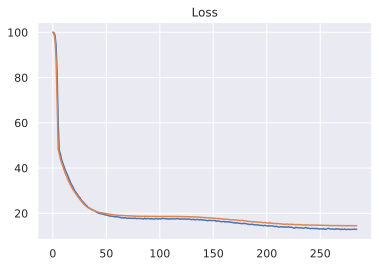

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 14.51%


In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [ ]:
sample_submission.head()

,sell_id,price
0,1099427284,2.991498e+05
1,1096405886,2.758663e+06
2,1100195294,5.970196e+05
3,1099827282,5.076059e+05
4,1100076198,2.656103e+06


Простая нейросеть себя показала хуже, чем дерево решений  
Теперь применим нейросети NLP и CV

# Model 4: NLP + Multiple Inputs

In [ ]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
# понижаем регистр

data['desc'] = data['description'].map(lambda x: x.lower())

In [ ]:
#def preprocess_text(sen):
#    sentence = sen

    # Single character removal
#    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
#    sentence = re.sub(r'\s+', ' ',  sentence)

#    return sentence
#data['desc2'] = data['desc'].apply(preprocess_text)

In [ ]:
# с помощью цикла создадим функцию удаления знаков препинания

def remove_punctuation(text):
    for char in punctuation:
        text = text.replace(char, '')
    return text

# удаляем в текстах знаки препинания
data['desc'] = data['desc'].apply(remove_punctuation)

In [ ]:
russian_stopwords = stopwords.words("russian")
add_words = ['\n','❤️', '•', '∙', '●', '☑️', '☛', '✅', '✔', '➥', 'ваш', 'вашего']
russian_stopwords = russian_stopwords + add_words

In [ ]:
# удаляем стоп-слова из текстов

data['desc'] = data['desc'].apply(lambda x: " ".join([word for word in x.split() if word not in russian_stopwords]))

In [ ]:
morph = MorphAnalyzer()

def lemmatize_text(str):
  # лемматизации текста :
    split_str = str.split()
    filtered_str = ' '.join(
        (map(lambda x: morph.parse(x)[0].normal_form, split_str)))
    return filtered_str


data['desc'] = data['desc'].apply(lemmatize_text)

In [ ]:
# Сильно ухудшает результат такой вид аугментации

#def rand_aug(row):
#    aug = nac.RandomCharAug(action="insert")
#    augmented_text = aug.augment(row)
#    return augmented_text

#data['desc'] = data['desc'].apply(rand_aug)

Аугментация рандомной замены букв сильно ухудшила результат.  
Не стала пробовать аугментацию синонимами, потому что в случае машин есть разница между хорошим и прекрасным состоянием автомобиля

Создадим облако слов, и самые популярные заменим на кодовые слова

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


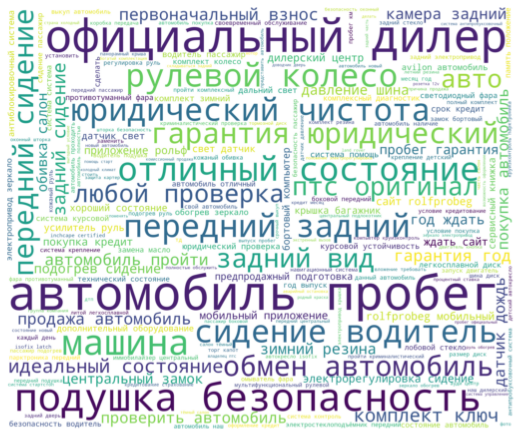

In [ ]:
corpus = get_corpus(data['desc'])
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 1)

In [ ]:
# Количество уникальных слов в тексте
num_words = len(set(corpus))
num_words

32284

Итак, после лемматизации количество уникальных слов - 

In [ ]:
data['desc'] = data['desc'].apply(lambda x: x.replace('машина', 'автомобиль'))
data['desc'] = data['desc'].apply(lambda x: x.replace('тачилу', 'автомобиль'))
data['desc'] = data['desc'].apply(lambda x: x.replace('тачка', 'автомобиль'))
data['desc'] = data['desc'].apply(lambda x: x.replace('официальный дилер', 'код0'))
data['desc'] = data['desc'].apply(lambda x: x.replace('подогрев задний сидение', 'код1'))
data['desc'] = data['desc'].apply(lambda x: x.replace('отличный состояние', 'код3'))
data['desc'] = data['desc'].apply(lambda x: x.replace('идеальный состояние', 'код3'))
data['desc'] = data['desc'].apply(lambda x: x.replace('проверить автомобиль пробег', 'код4'))
data['desc'] = data['desc'].apply(lambda x: x.replace('подушка безопасность', 'код5'))
data['desc'] = data['desc'].apply(lambda x: x.replace('рулевой колесо', 'код6'))
data['desc'] = data['desc'].apply(lambda x: x.replace('гарантия юридический чистота', 'код7'))
data['desc'] = data['desc'].apply(lambda x: x.replace('юридический чистота', 'код7'))
data['desc'] = data['desc'].apply(lambda x: x.replace('гарантия юридический', 'код7'))
data['desc'] = data['desc'].apply(lambda x: x.replace('любой проверка', 'код8'))
data['desc'] = data['desc'].apply(lambda x: x.replace('первоначальный взнос', 'код9'))
data['desc'] = data['desc'].apply(lambda x: x.replace('камера задний вид', 'код10'))
data['desc'] = data['desc'].apply(lambda x: x.replace('зимний резина', 'код11'))
data['desc'] = data['desc'].apply(lambda x: x.replace('обивка салон', 'код12'))
data['desc'] = data['desc'].apply(lambda x: x.replace('птс оригинал', 'код13'))
data['desc'] = data['desc'].apply(lambda x: x.replace('tradein', 'код14'))
data['desc'] = data['desc'].apply(lambda x: x.replace('трейдин', 'код14'))
data['desc'] = data['desc'].apply(lambda x: x.replace('покупка кредит', 'код15'))
data['desc'] = data['desc'].apply(lambda x: x.replace('rolfprobeg мобильный приложение', 'код16'))
data['desc'] = data['desc'].apply(lambda x: x.replace('приложение рольф', 'код16'))
data['desc'] = data['desc'].apply(lambda x: x.replace('сайт rolfprobeg', 'код16'))
data['desc'] = data['desc'].apply(lambda x: x.replace('rolfprobeg мобильный', 'код16'))
data['desc'] = data['desc'].apply(lambda x: x.replace('мобильный приложение', 'код16'))
data['desc'] = data['desc'].apply(lambda x: x.replace('гарантия год', 'код17'))
data['desc'] = data['desc'].apply(lambda x: x.replace('датчик дождь', 'код18'))
data['desc'] = data['desc'].apply(lambda x: x.replace('свет датчик', 'код19'))
data['desc'] = data['desc'].apply(lambda x: x.replace('датчик свет', 'код19'))
data['desc'] = data['desc'].apply(lambda x: x.replace('давление шина', 'код20'))
data['desc'] = data['desc'].apply(lambda x: x.replace('комплект ключ', 'код21'))
data['desc'] = data['desc'].apply(lambda x: x.replace('бортовый компьютер', 'код22'))
data['desc'] = data['desc'].apply(lambda x: x.replace('датчик дождь', 'код23'))
data['desc'] = data['desc'].apply(lambda x: x.replace('предпродажный подготовка', 'код24'))
data['desc'] = data['desc'].apply(lambda x: x.replace('усилитель руль', 'код25'))
data['desc'] = data['desc'].apply(lambda x: x.replace('центральный замок', 'код26'))
data['desc'] = data['desc'].apply(lambda x: x.replace('дополнительный оборудование', 'код27'))
data['desc'] = data['desc'].apply(lambda x: x.replace('система помощь', 'код28'))
data['desc'] = data['desc'].apply(lambda x: x.replace('система курсовой', 'код29'))
data['desc'] = data['desc'].apply(lambda x: x.replace('сервисный книжка', 'код30'))
data['desc'] = data['desc'].apply(lambda x: x.replace('электрорегулировка сидение', 'код31'))
data['desc'] = data['desc'].apply(lambda x: x.replace('круизконтроль', 'код32'))
data['desc'] = data['desc'].apply(lambda x: x.replace('климатконтроль', 'код33'))

Представленный ниже способ со словарем сработал не во всех случаях, так что выше вы видите громадную точечную замену слов

In [ ]:
# словарь замен частых слов и выражений на коды
#dict_replace = {
# 'автомобиль': ['машина', 'тачилу', 'тачка'],
# 'код0': ['официальный дилер'],
# 'код1': ['подогрев задний сидение'],
# 'код3': ['отличный состояние', 'идеальный состояние'],
# 'код5': ['проверить автомобиль пробег','автомобиль пробег', 'автомобиль пробег гарантия'],
# 'код6': ['подушка безопасность'],
# 'код7': ['рулевой колесо'],
# 'код8': ['гарантия юридический чистота',
#  'юридический чистота',
#  'гарантия юридический'],
# 'код9': ['любой проверка'],
# 'код10': ['первоначальный взнос'],
# 'код11': ['камера задний вид'],
# 'код12': ['зимний резина'],
# 'код13': ['обивка салон'],
# 'код14': ['птс оригинал'],
# 'код15': ['trade in',
#  'трейд-ин'],
# 'код16': ['передний сидение', 'сидение водитель'],
# 'код17': ['покупка кредит'],
# 'код18': ['rolfprobeg мобильный приложение',
#  'приложение рольф',
#  'сайт rolfprobeg',
#  'rolfprobeg мобильный',
#  'мобильный приложение'],
# 'код19': ['гарантия год'],
# 'код20': ['датчик дождь'],
# 'код21': ['свет датчик', 'датчик свет'],
# 'код22': ['давление шина'],
# 'код23': ['комплект ключ'],
# 'код24': ['бортовый компьютер'],
# 'код25': ['предпродажный подготовка'],
# 'код26': ['усилитель руль'],
# 'код27': ['центральный замок']}

In [ ]:
#for elem in dict_replace:
#    for word in dict_replace[elem]:
#        data['desc'] = data['desc'].apply(lambda x: x.replace(word, elem))

In [ ]:
data['desc']

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес тюнинг hamman ез...
2       автомобиль продаваться первый перебрать двигат...
3       автомобиль код3 весь родный краска краситься б...
4       немка бесключивый доступ код10 автомобиль плён...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить код0 2017 г третий владелец владелец фи...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль код3 3из авто семья обслуживание пр...
8352    удлинённый заводский pullman база w140 вообщет...
Name: desc, Length: 8353, dtype: object

In [ ]:
# Количество уникальных слов в тексте
num_words = len(set(corpus))
num_words

32284

### Tokenizer

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# split данных
text_train = data.desc.iloc[X_train.index]
text_test = data.desc.iloc[X_test.index]
text_sub = data.desc.iloc[X_sub.index]

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.desc)

CPU times: user 1.02 s, sys: 1.59 ms, total: 1.02 s
Wall time: 1.02 s


In [ ]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'год': 5,
 'салон': 6,
 'сидение': 7,
 'передний': 8,
 'диск': 9,
 'новый': 10,
 'фара': 11,
 'состояние': 12,
 '2': 13,
 'комплект': 14,
 'авто': 15,
 'пакет': 16,
 'комплектация': 17,
 'кредит': 18,
 'код0': 19,
 'обмен': 20,
 'зеркало': 21,
 'продажа': 22,
 'полный': 23,
 'bmw': 24,
 'водитель': 25,
 'руль': 26,
 '000': 27,
 'пассажир': 28,
 'код3': 29,
 'условие': 30,
 'двигатель': 31,
 'владелец': 32,
 'технический': 33,
 'кузов': 34,
 'обогрев': 35,
 'хороший': 36,
 'обслуживание': 37,
 'подогрев': 38,
 'код5': 39,
 'стекло': 40,
 'масло': 41,
 'торг': 42,
 'покупка': 43,
 'замена': 44,
 'дверь': 45,
 'пройти': 46,
 '1': 47,
 '6': 48,
 'колесо': 49,
 'гарантия': 50,
 'чёрный': 51,
 'проверка': 52,
 'наш': 53,
 'электропривод': 54,
 'купить': 55,
 'шина': 56,
 'оригинальный': 57,
 'км': 58,
 '–': 59,
 'птс': 60,
 'кожа': 61,
 'дтп': 62,
 'каждый': 63,
 'автоматический': 64,
 'документ': 65,
 'функция': 66,
 'рольф': 67,

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.01 s, sys: 1.57 ms, total: 1.01 s
Wall time: 1.01 s


In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить 110 пункт автокредит специальный ставка 137 ауди центр север код0 audi входящий группа компания рольф являться один крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться код3 убедиться правильный выбор возможность пройти тестдрайв ― ознакомительный поездка интересовать автомобиль смочь ознакомиться автомобиль выходить дом – наш менеджер провести online презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать хороший условие кредитование 6 000 код4 гарантия 2 год ждать сайт код16 рольф
[   0    0    0    0    0    0    0    0    0    0    0   

### BERT model

К сожалению, не удалось установить все необходимое для преобученной модели BERT  
Будем использовать реккурентную и стандартную модели

In [ ]:
#tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'
#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4'

#def build_bert_model():
#    text_input = L.Input(shape=(), dtype=tf.string, name='text')
#    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
#    encoder_inputs = preprocessing_layer(text_input)
#    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
#    outputs = encoder(encoder_inputs)
#    net = outputs['pooled_output']
#    net = L.Dropout(0.1)(net)
#    net = L.Dense(1, activation=None, name='classifier')(net)
#    return tf.keras.Model(text_input, net)

In [ ]:
#bert_model = build_bert_model()

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8272896     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-5)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                   )

Epoch 1/500
12/12 [==============================] - 4s 337ms/step - loss: 99.9907 - MAPE: 99.9907 - val_loss: 99.8851 - val_MAPE: 99.8851
Epoch 2/500
12/12 [==============================] - 4s 301ms/step - loss: 98.8813 - MAPE: 98.8813 - val_loss: 94.7974 - val_MAPE: 94.7974
Epoch 3/500
12/12 [==============================] - 3s 291ms/step - loss: 82.4055 - MAPE: 82.4055 - val_loss: 52.6729 - val_MAPE: 52.6729
Epoch 4/500
12/12 [==============================] - 3s 277ms/step - loss: 50.9745 - MAPE: 50.9745 - val_loss: 46.2814 - val_MAPE: 46.2814
Epoch 5/500
12/12 [==============================] - 3s 274ms/step - loss: 44.9216 - MAPE: 44.9216 - val_loss: 42.5864 - val_MAPE: 42.5864
Epoch 6/500
12/12 [==============================] - 3s 282ms/step - loss: 41.5575 - MAPE: 41.5575 - val_loss: 38.7051 - val_MAPE: 38.7051
Epoch 7/500
12/12 [==============================] - 3s 273ms/step - loss: 38.2637 - MAPE: 38.2637 - val_loss: 35.7017 - val_MAPE: 35.7017
Epoch 8/500
12/12 [========

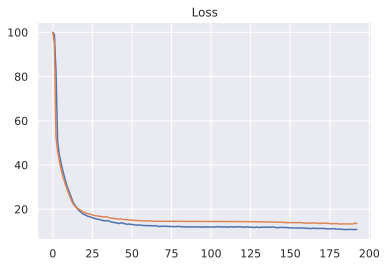

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 13.45%


In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [ ]:
sample_submission.head()

,sell_id,price
0,1099427284,3.524198e+05
1,1096405886,2.578190e+06
2,1100195294,5.930154e+05
3,1099827282,5.274803e+05
4,1100076198,2.639693e+06


Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

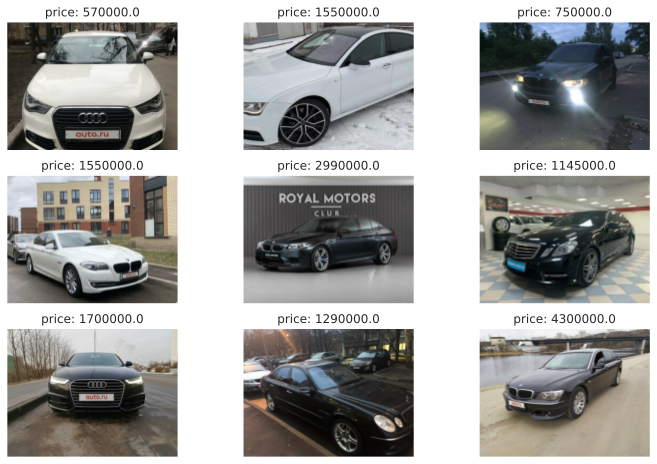

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

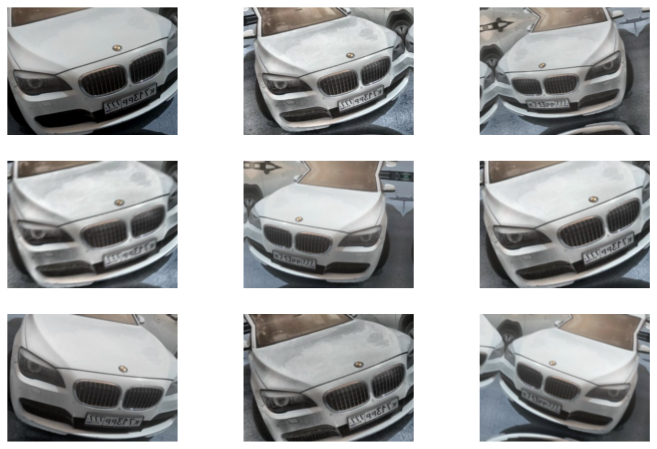

In [ ]:
from albumentations import ( HorizontalFlip, CLAHE, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = Compose([
    CLAHE(p=0.3),
    RandomBrightnessContrast(p=0.2),
    HorizontalFlip(),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        MotionBlur(p=0.2),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
    ], p=0.2),
    HueSaturationValue(p=0.2),
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

Не будем обучать всю модель сразу

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
base_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
base_model.trainable = False
efficientnet_output = L.GlobalAveragePooling2D()(base_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[base_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-5)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=300,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/300
190/190 [==============================] - 63s 331ms/step - loss: 46.1529 - MAPE: 46.1529 - val_loss: 26.2797 - val_MAPE: 26.2797
Epoch 2/300
190/190 [==============================] - 61s 319ms/step - loss: 22.9383 - MAPE: 22.9383 - val_loss: 18.9171 - val_MAPE: 18.9171
Epoch 3/300
190/190 [==============================] - 59s 310ms/step - loss: 18.2971 - MAPE: 18.2971 - val_loss: 16.7922 - val_MAPE: 16.7922
Epoch 4/300
190/190 [==============================] - 59s 312ms/step - loss: 16.5583 - MAPE: 16.5583 - val_loss: 15.2697 - val_MAPE: 15.2697
Epoch 5/300
190/190 [==============================] - 59s 311ms/step - loss: 15.2571 - MAPE: 15.2571 - val_loss: 15.4569 - val_MAPE: 15.4569
Epoch 6/300
190/190 [==============================] - 60s 316ms/step - loss: 14.6363 - MAPE: 14.6363 - val_loss: 14.4527 - val_MAPE: 14.4527
Epoch 7/300
190/190 [==============================] - 61s 319ms/step - loss: 14.3505 - MAPE: 14.3505 - val_loss: 14.0906 - val_MAPE: 14.0906
Epoch 

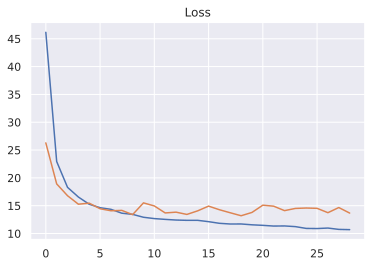

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.68%


Разморозим половину модели.

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-5)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=500,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/500
190/190 [==============================] - 71s 374ms/step - loss: 10.9157 - MAPE: 10.9157 - val_loss: 46.5115 - val_MAPE: 46.5115
Epoch 2/500
190/190 [==============================] - 68s 359ms/step - loss: 10.7536 - MAPE: 10.7536 - val_loss: 14.2182 - val_MAPE: 14.2182
Epoch 3/500
190/190 [==============================] - 68s 356ms/step - loss: 10.8991 - MAPE: 10.8991 - val_loss: 13.7040 - val_MAPE: 13.7040
Epoch 4/500
190/190 [==============================] - 67s 352ms/step - loss: 10.9899 - MAPE: 10.9899 - val_loss: 19.3887 - val_MAPE: 19.3887
Epoch 5/500
190/190 [==============================] - 68s 360ms/step - loss: 10.6194 - MAPE: 10.6194 - val_loss: 13.8268 - val_MAPE: 13.8268
Epoch 6/500
190/190 [==============================] - 68s 358ms/step - loss: 10.6156 - MAPE: 10.6156 - val_loss: 13.1108 - val_MAPE: 13.1108
Epoch 7/500
190/190 [==============================] - 68s 360ms/step - loss: 10.8476 - MAPE: 10.8476 - val_loss: 14.2215 - val_MAPE: 14.2215
Epoch 

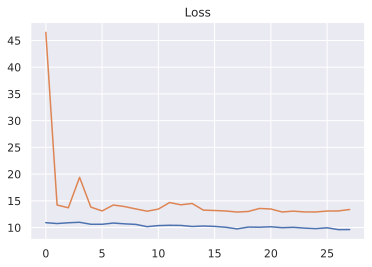

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.38%


Разморозим оставшуюся часть

In [ ]:
base_model.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-5)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=300,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/300
190/190 [==============================] - 135s 708ms/step - loss: 9.4664 - MAPE: 9.4664 - val_loss: 3275.3865 - val_MAPE: 3275.3865
Epoch 2/300
190/190 [==============================] - 132s 693ms/step - loss: 9.5762 - MAPE: 9.5762 - val_loss: 14.7973 - val_MAPE: 14.7973
Epoch 3/300
190/190 [==============================] - 133s 701ms/step - loss: 9.6524 - MAPE: 9.6524 - val_loss: 13.1102 - val_MAPE: 13.1102
Epoch 4/300
190/190 [==============================] - 132s 695ms/step - loss: 9.5422 - MAPE: 9.5422 - val_loss: 28.9232 - val_MAPE: 28.9232
Epoch 5/300
190/190 [==============================] - 130s 682ms/step - loss: 9.6289 - MAPE: 9.6289 - val_loss: 24.4432 - val_MAPE: 24.4432
Epoch 6/300
190/190 [==============================] - 131s 690ms/step - loss: 9.7135 - MAPE: 9.7135 - val_loss: 13.4722 - val_MAPE: 13.4722
Epoch 7/300
190/190 [==============================] - 132s 695ms/step - loss: 9.6189 - MAPE: 9.6189 - val_loss: 13.1192 - val_MAPE: 13.1192
Epoch 8/3

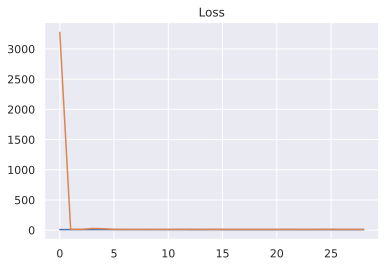

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.91%


In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [ ]:
sample_submission.head()

,sell_id,price
0,1099427284,373451.250
1,1096405886,2550453.500
2,1100195294,550465.875
3,1099827282,548946.375
4,1100076198,2586954.000



#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.21%


In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 1584)]       0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          811520      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
cos_annLR = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-5)
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, cos_annLR]

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=300, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/300
12/12 [==============================] - 0s 27ms/step - loss: 99.9898 - MAPE: 99.9898 - val_loss: 99.8619 - val_MAPE: 99.8619
Epoch 2/300
12/12 [==============================] - 0s 12ms/step - loss: 98.5561 - MAPE: 98.5561 - val_loss: 93.2268 - val_MAPE: 93.2268
Epoch 3/300
12/12 [==============================] - 0s 12ms/step - loss: 77.0664 - MAPE: 77.0664 - val_loss: 47.3299 - val_MAPE: 47.3299
Epoch 4/300
12/12 [==============================] - 0s 12ms/step - loss: 50.9705 - MAPE: 50.9705 - val_loss: 44.2167 - val_MAPE: 44.2167
Epoch 5/300
12/12 [==============================] - 0s 11ms/step - loss: 45.1053 - MAPE: 45.1053 - val_loss: 41.4989 - val_MAPE: 41.4989
Epoch 6/300
12/12 [==============================] - 0s 12ms/step - loss: 40.7513 - MAPE: 40.7513 - val_loss: 37.9620 - val_MAPE: 37.9620
Epoch 7/300
12/12 [==============================] - 0s 12ms/step - loss: 37.7261 - MAPE: 37.7261 - val_loss: 35.0314 - val_MAPE: 35.0314
Epoch 8/300
12/12 [===============

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 14.89%
